# Analysis Perspective: Cast and Crew Recommendations 

## Business Outcome

   The business recommendation I will be delivering to the Microsoft Studio team will be ordered lists of the actors and crew members whose movies made the most money over the last ten years, measured by net profit. This is to ensure that once the studio is up and running, the creatives associated with the most profitable films of the last ten years can be hired. This will ensure that Microsoft Studio's investment in personnel is as fruitful as possible. 

## The Data

The data used in this analysis comes mostly from [IMDB](https://www.imdb.com/?ref_=nv_home), the go-to online database for information about movies. IMDB is so perfect for this analysis because it painstakingly tracks all the people involved in the making of movies, where many other websites simply track reviews. 

The one caveat to this is that IMDB does not track financial data for the films in its database. The revenues and profitability of the last decade's films are at the core of the business insights I will deliver to the Microsoft Studios team. So I will combine IMDB's cast and crew data with movie accounting information from [The Numbers](https://www.the-numbers.com/), a website wholly devoted to recording movie revenues. 

IMDB has a massive catalogue of films, which for us is a double edged sword. While this quantity of information makes for robust analysis, it also enhances the complexity of our process. 

## Step 1. Importing Tools and the Information

First we need to import the libraries we will use for performing data exploration, analysis and visualization. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Next lets import the files we need. 

In [2]:
# Turning the relevant csv files into pandas dataframes we can work with

name_keys = pd.read_csv('imdb.name.basics.csv')

title_keys = pd.read_csv('imdb.title.akas.csv')

names_to_jobs = pd.read_csv('imdb.title.principals.csv')

financials = pd.read_csv('tn.movie_budgets.csv')

## Step 2. Preparing our Dataframes 

### Step 2.1. Name Keys

As our dataframes stand right now, they contain unneccessary data, redundant data, and null values. 

When examining the first rows of the IMDB dataframes, I noticed that titles and names are often stored as codes instead of plain-text. I realized this is due to the fact that IMDB is a global website, and movies have a global audience, so instead of storing redundant data in every language, they store information under name and title codes. Much of our data preperation will be translating coded names and titles into their plain-text english versions. 

name_keys is the first dataframe I will prepare. The label I have chosen for this dataframe is due to the fact that it ties imdb's internal name codes to the real world names of the cast and crew members. 

To prepare this dataframe, I will remove any rows where the death_year column is not NaN, as I cant recommend Microsoft Studios attempt to hire the deceased to work on their upcoming projects.

I will then remove all columns except nconst and primary_name, as I am only interested in the values in these two columns.

In [3]:
name_keys.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [4]:
##problem not yet solved here , still have dead people in our data
# Selecting all the rows with Null values in the death_year column, then selecting the columns I want.
name_keys = name_keys[['nconst', 'primary_name']]
name_keys.head()

,nconst,primary_name
0,nm0061671,Mary Ellen Bauder
1,nm0061865,Joseph Bauer
2,nm0062070,Bruce Baum
3,nm0062195,Axel Baumann
4,nm0062798,Pete Baxter


### Step 2.2. Title Keys

This dataframe is named title_keys because much like name_keys, it will allow us to tie the english titles of movies to IMDB's internal title code for those movies. 

To prepare this dataframe we will select only rows where the region is US, because our financials table has both domestic and international revenue data, so we only need the US titles to access global revenue data. 

The last cleaning step to perform is to keep in mind that IMDB does not provide financial data, so we are going to have to merge our IMDB dataframes with our financial dataframe, to facilitate this merge, I will write a function to remove all whitespace, capitalizations, and punctuation in case they differ between the two different dataframes. We can resuse this funciton later on to clean the financials title column in the same way. 

Then we will grab only the title_id and title columns, as these will serve as our keys, and none of the other coumns serve our specific analysis goal. 

In [5]:
# Grabbing the relevant columns
title_keys = title_keys.loc[title_keys['region'] == 'US', ['title_id', 'title']]

# Our title cleaning function
def title_cleaner(string):
    new_string = ''
    alpha = 'abcdefghijklmnopqrstuvwxyz0123456789'
    string = string.lower()
    for i in string:
        if i in alpha:
            new_string += i
    return new_string
    
# Creating a new column filled with cleaned titles
title_keys['clean_title'] = title_keys['title'].map(title_cleaner)
    
# Getting rid of the original title name column 
title_keys = title_keys[['title_id','clean_title']]

# Sanity Check 
title_keys.head()

,title_id,clean_title
12,tt0369610,jurassicworld3d
20,tt0369610,jurassicworld
21,tt0369610,ebbtide
28,tt0369610,jurassicparkiv
37,tt0369610,jurassicpark4


### Step 2.3. Names and Jobs

The names_to_jobs dataframe lists movies (as their IMDB title codes) , and the names of people who worked on them (as their IMDB name codes) as well as their role in the production, and character name if they are an actor. 

This dataframe will eventually serve as the base for the final combined dataframe we will run our analysis on. 

To clean up this dataframe, we will drop rows with NaN values, and select the columns of interest to us, which are tconst, nconst, and category

In [6]:
# Removing rows with Null values in essential columns
names_to_jobs.dropna(subset=['tconst', 'nconst', 'category'])

# Selecting only those essential columns 
names_to_jobs = names_to_jobs[['tconst', 'nconst', 'category']]

# Sanity check
names_to_jobs.head()

,tconst,nconst,category
0,tt0111414,nm0246005,actor
1,tt0111414,nm0398271,director
2,tt0111414,nm3739909,producer
3,tt0323808,nm0059247,editor
4,tt0323808,nm3579312,actress


### Step 2.4. The Financials

The final dataframe required is the financials dataframe. This dataframe is critical to our cast and crew analysis because it contains the accounting data we will use to calculate the profit of each movie.

Our team has decided to only look at movies released in the last ten years. We believe this achieves a balance between sample size, and not including movies that are too old to be relevant. To meet this goal I will convert the last 4 elements of the strings in the release_date column to an integer to obtain the year, and filter my dataframe based on the result. 

The next issue we need to deal with is turning the numbers, stored as strings, into integers so we can perform arithmetic operations on them. We can achieve this by replacing the $ with nothing, then using the int() function. 

I can then subtract the budget from the global box office numbers to calculate net profit. 



Finally we will apply our title cleaning function from above, and select only the columns of interest to us. 

In [7]:
# Defining our string to integer conversion function, to get year as a number
def convert_year(string):
    return int(string[-4:])

# Creating a new column year by applying our conversion function to the 'release date' column
financials['year'] = financials['release_date'].map(convert_year)

# Getting only the rows from the last ten years 
financials = financials.loc[ financials['year'] >= 2011 ]

# Defining our function to convert the dolalr amounts stored as strings into integers
def convert_money(string):
    return int(string.replace('$','').replace(',',''))

# Making two new columns to hold our integer money values
financials['budget'] = financials['production_budget'].map(convert_money)
financials['global_gross'] = financials['worldwide_gross'].map(convert_money)

# Making a net profit column 
financials['net_profit'] = financials['global_gross'] - financials['budget']

# Creating a clean name column to hold the results of our title cleaning function
financials['clean_name'] = financials['movie'].map(title_cleaner)

# Selecting our shiny new processed columns
financials = financials[['clean_name', 'budget', 'net_profit']]

# Sanity check after all of those changes
financials.head()

,clean_name,budget,net_profit
1,piratesofthecaribbeanonstrangertides,410600000,635063875
2,darkphoenix,350000000,-200237650
3,avengersageofultron,330600000,1072413963
4,starwarsepviiithelastjedi,317000000,999721747
5,starwarsepviitheforceawakens,306000000,1747311220


## Step 3. Combining our Processed Dataframes

Now that all of our dataframes are better formatted, lets start smashing them together into something more useful. With names_to_jobs as our base structure to build upon, we will combine our dataframes in a series of three merges.

Merge 1 is combining names_to_jobs with name_keys. This will allow us to see the plain text english names of all the people listed in our names_to_jobs dataframe. 

Merge 2 is connecting our merge 1 dataframe to title_keys, this translates our IMDB title codes into plain text movie title names. 

Merge 3 is combining the merge 2 dataframe, which is all IMDB information with our outside financial data. These two dataframes will be stitched together based on their cleaned and stripped title columns. 

Then after looking at the data I noticed that several rows where the title columns were empty, and the financial data was repeating in a very suspicious pattern, so I removed any rows that did not have a title name. 

Finally I used drop_duplicates so that our data would not be skewed by repeated rows. 

In [8]:
# Adding the plain-text names onto our main dataframe
merged = names_to_jobs.merge(name_keys, left_on=['nconst'], right_on=['nconst'])

# Adding the plain-text titles onto our main dataframe 
merged_2 = merged.merge(title_keys, left_on=['tconst'], right_on=['title_id'])

# Adding the financial data onto our main dataframe where the seperately cleaned titles match up
merged_3 = merged_2.merge(financials, left_on=['clean_title'], right_on=['clean_name'])

# Removing rows without titles that were exhibiting suspicious activity 
cleaned_merged_3 = merged_3.loc[ merged_3['clean_title'] != '']

# Dropping duplicate rows to ensure our net profits are not inflated by counting rows multiple times
cleaned_merged_3 = cleaned_merged_3.drop_duplicates()


# The all important sanity check
cleaned_merged_3.iloc[3000:3005]

,tconst,nconst,category,primary_name,title_id,clean_title,clean_name,budget,net_profit
3150,tt1608290,nm0542802,producer,Jeff Mann,tt1608290,zoolander2,zoolander2,50000000,5348693
3151,tt1608290,nm0766153,writer,Drake Sather,tt1608290,zoolander2,zoolander2,50000000,5348693
3152,tt6781982,nm0831557,writer,Nicholas Stoller,tt6781982,nightschool,nightschool,29000000,74008792
3153,tt6781982,nm0539082,actor,Romany Malco,tt6781982,nightschool,nightschool,29000000,74008792
3154,tt6781982,nm0366389,actor,Kevin Hart,tt6781982,nightschool,nightschool,29000000,74008792


## Step 4. Grouping by Job Title, Ordering by Performance

Now that we have our final, composite dataframe, we can extract wisdom out of the data. This specific analysis perspective calls for the grouping of rows based on job title, and then ordering the results by sum net profits. What this will provide for us is a collection of lists, telling us in descending order who the most commercially successful directors, producers, actors, actresses, and writers are. 

In [9]:
# Sorting our final dataframe by the job title 'director', then sorting by descending sum of net profits
directors = cleaned_merged_3.loc[ cleaned_merged_3['category'] == 'director']
directors = directors.groupby(['primary_name']).sum().sort_values(['net_profit'], ascending=False)
directors = directors.iloc[:15, : ]

# Repeating the process for producers
producers = cleaned_merged_3.loc[ cleaned_merged_3['category'] == 'producer']
producers = producers.groupby(['primary_name']).sum().sort_values(['net_profit'], ascending=False)
producers = producers.iloc[:15, : ]

# Repeating the process for actors
actors = cleaned_merged_3.loc[ cleaned_merged_3['category'] == 'actor']
actors = actors.groupby(['primary_name']).sum().sort_values(['net_profit'], ascending=False)
actors = actors.iloc[:15, : ]

# Repeating the process for actresses
actresses = cleaned_merged_3.loc[ cleaned_merged_3['category'] == 'actress']
actresses = actresses.groupby(['primary_name']).sum().sort_values(['net_profit'], ascending=False)
actresses = actresses.iloc[:15, : ]

# Repeating the process for writers
writers = cleaned_merged_3.loc[ cleaned_merged_3['category'] == 'writer']
writers = writers.groupby(['primary_name']).sum().sort_values(['net_profit'], ascending=False)
writers = writers.iloc[:15, : ]

# Sanity check incoming
directors.head()

,budget,net_profit
primary_name,,
Joe Russo,720000000,3182605502
Anthony Russo,720000000,3182605502
Joss Whedon,555600000,2365349860
Bill Condon,449700000,2334798666
Michael Bay,698000000,2283409620


## Step 5. Visualization and Summary 

Text(0, 0.5, 'Sum of Net Profits in Billions')

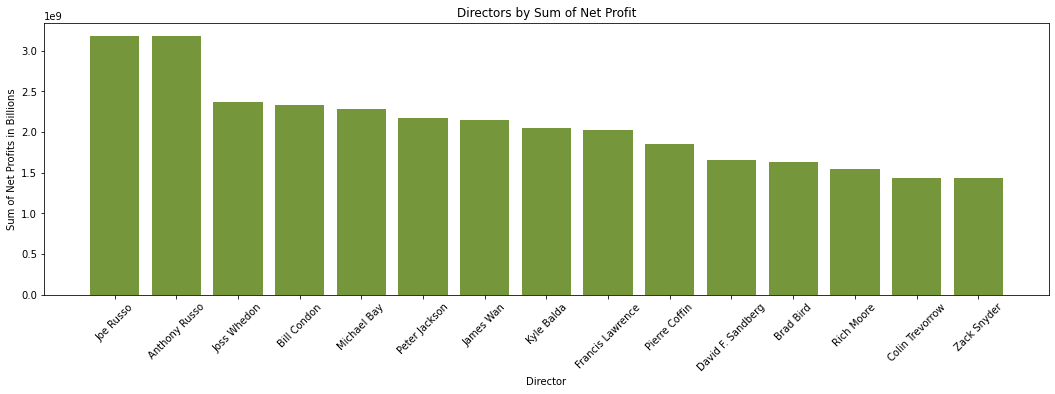

In [10]:
crew_recommendations, Directors = plt.subplots(figsize=(18, 5)) 
plt.xticks(rotation=45)
Directors.bar(directors.index, directors['net_profit'], color='#76963c')
Directors.set_title('Directors by Sum of Net Profit')
Directors.set_xlabel('Director')
Directors.set_ylabel('Sum of Net Profits in Billions')

Text(0, 0.5, 'Sum of Net Profits in Billions')

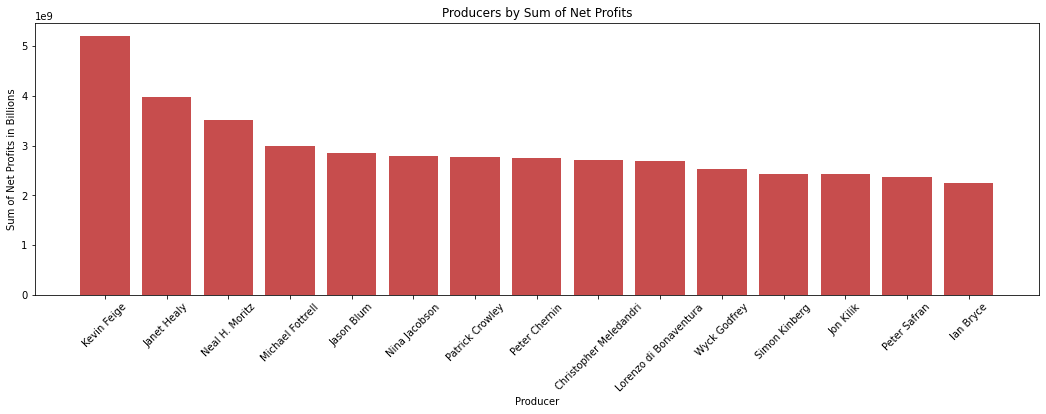

In [11]:
crew_recommendations, Producers = plt.subplots(figsize=(18, 5)) 
plt.xticks(rotation=45)
Producers.bar(producers.index, producers['net_profit'], color='#c74d4d')
Producers.set_title('Producers by Sum of Net Profits')
Producers.set_xlabel('Producer')
Producers.set_ylabel('Sum of Net Profits in Billions')

Text(0, 0.5, 'Sum of Net Profits in Billions')

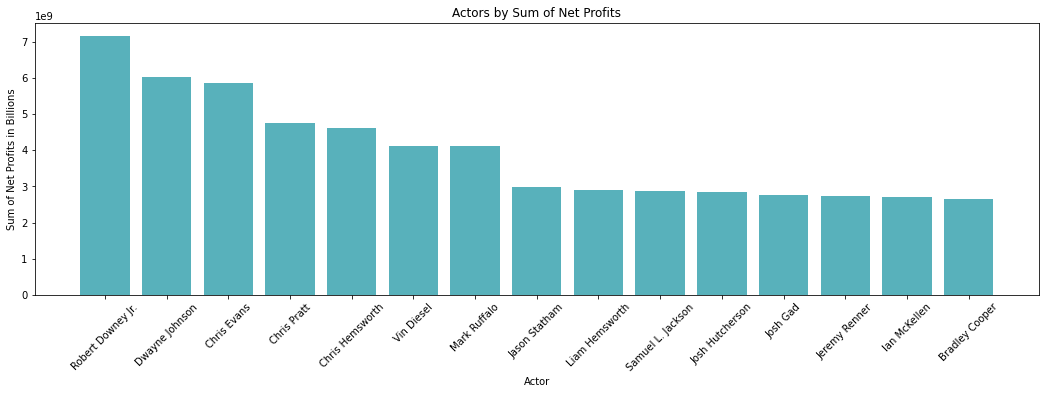

In [12]:
crew_recommendations, Actors = plt.subplots(figsize=(18, 5)) 
plt.xticks(rotation=45)
Actors.bar(actors.index, actors['net_profit'], color='#58b1bb')
Actors.set_title('Actors by Sum of Net Profits')
Actors.set_xlabel('Actor')
Actors.set_ylabel('Sum of Net Profits in Billions')

Text(0, 0.5, 'Sum of Net Profits in Billions')

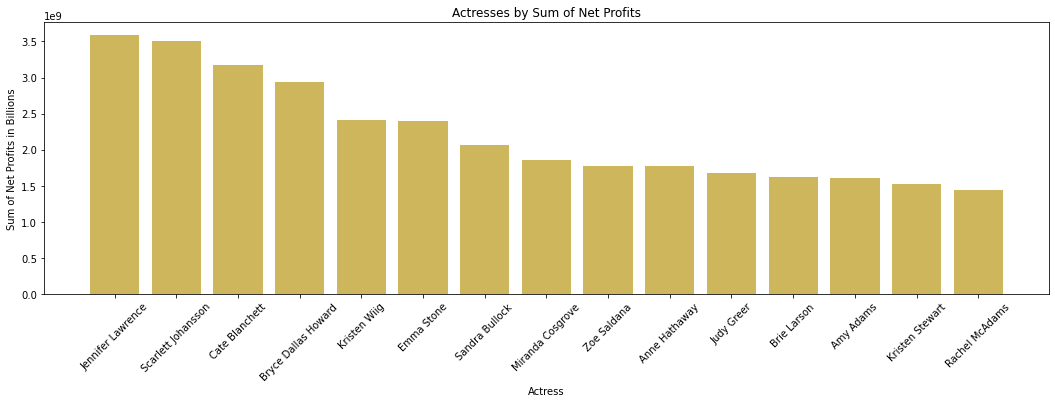

In [13]:
crew_recommendations, Actresses = plt.subplots(figsize=(18, 5)) 
plt.xticks(rotation=45)
Actresses.bar(actresses.index, actresses['net_profit'], color='#cdb65b')
Actresses.set_title('Actresses by Sum of Net Profits')
Actresses.set_xlabel('Actress')
Actresses.set_ylabel('Sum of Net Profits in Billions')

Text(0, 0.5, 'Sum of Net Profits in Billions')

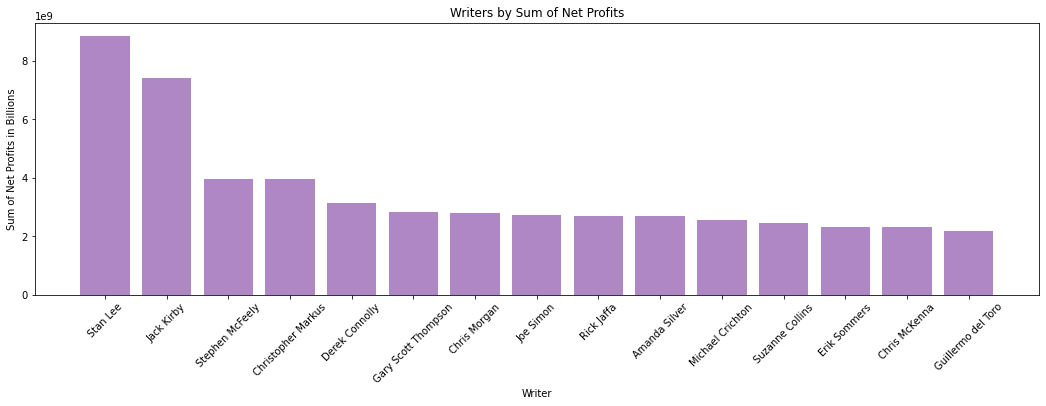

In [14]:
crew_recommendations, Writers = plt.subplots(figsize=(18, 5)) 
plt.xticks(rotation=45)
Writers.bar(writers.index, writers['net_profit'],  color='#af87c4')
Writers.set_title('Writers by Sum of Net Profits')
Writers.set_xlabel('Writer')
Writers.set_ylabel('Sum of Net Profits in Billions')